In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os 
os.chdir("/content/drive/My Drive/fast.ai v3/section 2/cust_dl_lib")

!git config --global user.email "rajp152000@gmail.com"
!git config --global user.name "rajp152k"
!pip install fire
import fire
datasets_path = "/content/drive/My Drive/fast.ai v3/datasets"

     |████████████████████████████████| 81kB 2.3MB/s 
  Created wheel for fire: filename=fire-0.2.1-py2.py3-none-any.whl size=103527 sha256=f2e4ac94b93c505d3eabcf7b5c27eac0871705c5cf8220aaa84a7022c7c0db53
  Stored in directory: /root/.cache/pip/wheels/31/9c/c0/07b6dc7faf1844bb4688f46b569efe6cafaa2179c95db821da
Successfully built fire


In [0]:
#export 
from exps.nb_04 import *

In [4]:
!git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/rajp152k/cust_dl_lib
   a618229..ca1190f  master     -> origin/master
Updating a618229..ca1190f
Fast-forward
 log.md | 5 +++++
 1 file changed, 5 insertions(+)


# prep

In [0]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train,y_train),Dataset(x_valid,y_valid)
nh,bs =  50,64
c = 10
loss_func = F.cross_entropy

In [0]:
data = DataBunch(*get_dls(train_ds,valid_ds,bs),c)

In [0]:
#export 
def create_learner(model_func,loss_func,data):
    return Learner(*model_func(data),loss_func,data)

In [8]:
learn = create_learner(get_model,loss_func,data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3,learn)

train: [0.3133901171875, tensor(0.9030)]
valid: [0.2423191162109375, tensor(0.9235)]
train: [0.1460450390625, tensor(0.9553)]
valid: [0.12279788818359375, tensor(0.9636)]
train: [0.106538330078125, tensor(0.9676)]
valid: [0.114509619140625, tensor(0.9659)]


In [9]:
learn = create_learner(partial(get_model,lr=0.3),loss_func,data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3,learn)

train: [0.34836078125, tensor(0.8958)]
valid: [0.18536651611328125, tensor(0.9471)]
train: [0.16037658203125, tensor(0.9521)]
valid: [0.18151488037109376, tensor(0.9464)]
train: [0.11890732421875, tensor(0.9643)]
valid: [0.1136200927734375, tensor(0.9658)]


In [0]:
#export 
def get_model_func(lr=0.5): return partial(get_model,lr=lr)

In [11]:
help(partial)

Help on class partial in module functools:

class partial(builtins.object)
 |  partial(func, *args, **keywords) - new function with partial application
 |  of the given arguments and keywords.
 |  
 |  Methods defined here:
 |  
 |  __call__(self, /, *args, **kwargs)
 |      Call self as a function.
 |  
 |  __delattr__(self, name, /)
 |      Implement delattr(self, name).
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __reduce__(...)
 |      helper for pickle
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  __setattr__(self, name, value, /)
 |      Implement setattr(self, name, value).
 |  
 |  __setstate__(...)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |  
 |  args
 |      tuple of arguments to future partial c

# Annealing

In [0]:
#export 
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return 
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())

    def plot_lr(self):plt.plot(self.lrs)
    def plot_loss(self):plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self,pname,sched_func):
        self.pname,self.sched_func = pname,sched_func
    
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
    def begin_batch(self):
        if self.in_train:self.set_param()

In [0]:
#export 
def annealer(f):
    def _inner(start,end): return partial(f,start,end)
    return _inner

@annealer
def sched_lin(start,end,pos): return start + pos*(end-start)

In [20]:
f = sched_lin(1,2)
f(0.2)

1.2

In [0]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

# to plot tensors:
torch.Tensor.ndim = property(lambda x: len(x.shape))

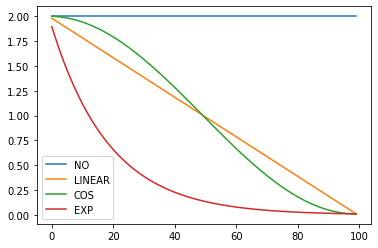

In [22]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

adding functionality to combine schedulers : say to mimic the fit1cycle training policy

In [0]:
#export 
def combine_scheds(pcts,scheds):
    assert sum(pcts) == 1
    pcts = tensor([0]+listify(pcts))
    assert torch.all(pcts>=0)
    pcts = torch.cumsum(pcts,0)
    def _inner(pos):
        idx = (pos>=pcts).nonzero().max()
        actual_pos = (pos-pcts[idx])/(pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

## Testing the schedulers

In [0]:
sched = combine_scheds([0.5,0.5],[sched_cos(0.3,0.6),sched_cos(0.6,0.2)])

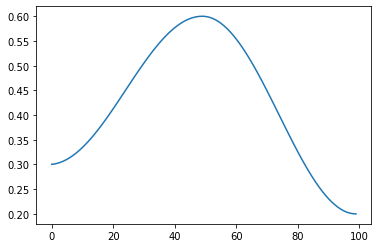

In [34]:
plt.plot(a,[sched(o) for o in p])

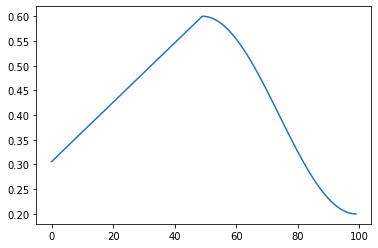

In [35]:
sched = combine_scheds([0.5,0.5],[sched_lin(0.3,0.6),sched_cos(0.6,0.2)])
plt.plot(a,[sched(o) for o in p])

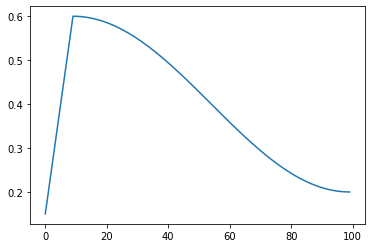

In [38]:
sched = combine_scheds([0.1,0.9],[sched_lin(0.1,0.6),sched_cos(0.6,0.2)])
plt.plot(a,[sched(o) for o in p])

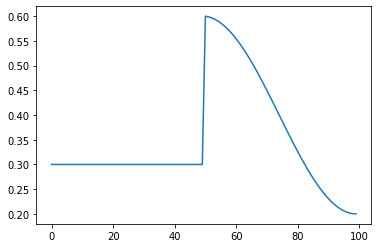

In [39]:
sched = combine_scheds([0.5,0.5],[sched_no(0.3,0.6),sched_cos(0.6,0.2)])
plt.plot(a,[sched(o) for o in p])

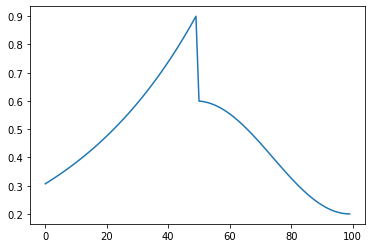

In [41]:
sched = combine_scheds([0.5,0.5],[sched_exp(0.3,0.9),sched_cos(0.6,0.2)])
plt.plot(a,[sched(o) for o in p])

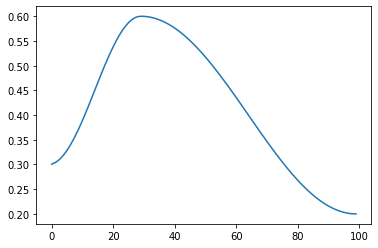

In [43]:
sched = combine_scheds([0.3,0.7],[sched_cos(0.3,0.6),sched_cos(0.6,0.2)])
plt.plot(a,[sched(o) for o in p])

In [0]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler,'lr',sched)]

In [0]:
learn = create_learner(get_model_func(lr = 0.3),loss_func,data)
run = Runner(cb_funcs=cbfs)

In [46]:
run.fit(3,learn)

train: [0.351960625, tensor(0.8946)]
valid: [0.328762255859375, tensor(0.8943)]
train: [0.149494072265625, tensor(0.9554)]
valid: [0.11358963623046875, tensor(0.9670)]
train: [0.09206310546875, tensor(0.9721)]
valid: [0.10049476318359375, tensor(0.9701)]


better 

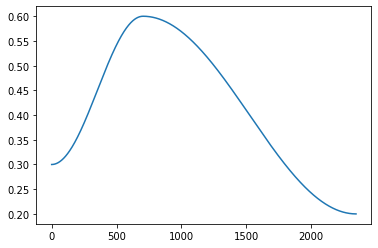

In [47]:
run.recorder.plot_lr()

gained fastai's recorder functionality

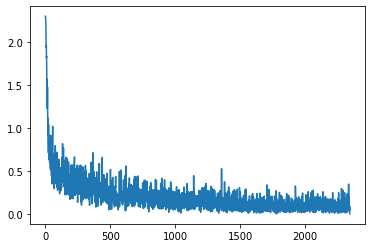

In [48]:
run.recorder.plot_loss()

In [50]:
!python3 notebook2script.py 05_annealing.ipynb

Converted 05_annealing.ipynb to exps/nb_05.py


In [0]:
!git add .
!git commit -m "annealing "